<a href="https://colab.research.google.com/github/b4435242/hardware-security/blob/main/dpa_hiding_time_no_trigger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Break AES using DPA with correlations

You need:
* `plaintext.txt`: all PT blocks, (one block per line, in hex, bytes separated by spaces)
* `ciphertext.txt`: all CT blocks, (one block per line, in hex, bytes separated by spaces)
* `traceLength.txt`: how many samples per trace (one decimal number)
* `traces.bin`: raw measured traces, one byte per sample (uint8), all traces together continuously


In [82]:
import matplotlib.pyplot as plt
import scipy
import numpy as np
from google.colab import drive
from scipy.spatial.distance import hamming
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [83]:
import sys
sys.path.append('/content/drive/Shared/hwb/lab03/SC_python_measurement')

In [84]:
# AES SBOX
sbox = np.array([
    0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
    0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
    0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
    0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
    0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
    0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
    0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
    0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
    0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
    0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
    0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
    0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
    0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
    0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
    0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
    0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
    ], dtype='uint8')

# Hamming weight lookup table
hw_table = []
for i in range(256):
    s = '{0:08b}'.format(i)
    hw_table.append(s.count('1'))
hw_table = np.array(hw_table, 'uint8')


def hamming_distance_matrix(matrix1, matrix2):
    # ensure the two matrices have the same shape
    assert matrix1.shape == matrix2.shape, "Matrices must have the same shape"

    # initialize the distance matrix
    distance_matrix = np.zeros(matrix1.shape)

    # iterate over the rows and columns of the matrices
    for i in range(matrix1.shape[0]):
        for j in range(matrix1.shape[1]):
            # calculate the Hamming distance between the elements at the same position
            r = (1 << np.arange(8))[:,None]
            distance_matrix[i, j] = np.count_nonzero(matrix1[i, j]&r != matrix2[i, j]&r)

    return distance_matrix


# Correlation of two matrices
def correlate(x, y):
    """
    Correlate all columns from matrix x of shape (a,b)
    with all columns from matrix y of shape (a,c),
    creating correlation matrix C of shape (b,c).
    
    Originally matlab script by Jiri Bucek in NI-HWB.
    """
    x = x - np.average(x, 0) # remove vertical averages
    y = y - np.average(y, 0) # remove vertical averages
    C = x.T @ y              # (n-1) Cov(x,y)
    C = C / (np.sum(x**2, 0)**(1/2))[:,np.newaxis] # divide by (n-1) Var(x)
    C = C / (np.sum(y**2, 0)**(1/2))               # divide by (n-1) Var(y)
    return C

# Load PT of CT from file
def load_text(file_name):
    """
    Load any text PT/CT from file containing hex strings with bytes 
    separated by spaces, one block per line
    Output is a matrix of bytes (np.array)
    """
    txt_str = open(file_name).readlines()
    del txt_str[-1] #discard last empty line
    #split each line into bytes and convert from hex
    txt_bytes_list = list(
        map(lambda line: 
                list(
                    map(lambda s: int(s, 16),
                        line.rstrip().split(" "))
                ),
            txt_str)
        )
    return np.array(txt_bytes_list, 'uint8')

def trace_compression(traces, num):
  return scipy.signal.resample(traces, num, axis=1)
  
def trace_alignment(traces):
  first_trace = traces[0]
  lags = []
  for i, trace in enumerate(traces):
    cross_corr = scipy.signal.correlate(first_trace, trace)
    lag = np.argmax(cross_corr) - (trace.shape[0]+1)
    lags.append(lag)
  # Set traces aligned to the most left point
  print(lags)
  most_left = min(lags)
  for i, trace in enumerate(traces):
    shift = lags[i] - most_left
    traces[i] = np.pad(trace[shift:], (0, shift), mode='constant') #shift and pad 0 at the end

  return traces

def trace_integration(traces, k):
  _traces = np.zeros((traces.shape[0], traces.shape[1]-k))
  for i, trace in enumerate(traces):
    trace_integrated = np.zeros(trace.shape[0]-k)
    sum = 0
    for j in range(0, k+1):
      sum += trace[j]
    trace_integrated[0] = sum
    for j in range(k+1, trace.shape[0]):
      sum += trace[j]
      sum -= trace[j-k-1]
      trace_integrated[j-k] = sum
    _traces[i] = trace_integrated
  return _traces    


In [85]:
def data_no_trigger():
  # read plaintext inputs
  inputs = load_text("/content/drive/MyDrive/lab05_AES_hiding_time/AES_no_trigger/aes_no_trigger_traces/plaintext.txt")

  # read length of one complete trace (number of samples per trace)
  with open("/content/drive/MyDrive/lab05_AES_hiding_time/AES_no_trigger/aes_no_trigger_traces/traceLength.txt", "r") as fin:
    trace_length = int(fin.readline())


  # trim each trace - select interesting part
  start = 140000
  end = 190000 # CHANGE to the length of the first round; 

  # read traces from binary file
  raw_traces = np.fromfile("/content/drive/MyDrive/lab05_AES_hiding_time/AES_no_trigger/aes_no_trigger_traces/traces.bin", dtype='uint8') # read as linear array
  raw_traces = np.reshape(raw_traces, (raw_traces.size // trace_length, trace_length)) # reshape into matrix
  raw_traces = raw_traces[:, start:end] # select only the interesting part of each trace
  return inputs, trace_length, raw_traces

def data_time_delay():
  # read plaintext inputs
  inputs = load_text("/content/drive/MyDrive/lab05_AES_hiding_time/hit3_1000_1ch/plaintext.txt")

  # read length of one complete trace (number of samples per trace)
  with open("/content/drive/MyDrive/lab05_AES_hiding_time/hit3_1000_1ch/traceLength.txt", "r") as fin:
    trace_length = int(fin.readline())


  # trim each trace - select interesting part
  start = 90000
  len = 190000 # CHANGE to the length of the first round; 

  # read traces from binary file
  raw_traces = np.fromfile("/content/drive/MyDrive/lab05_AES_hiding_time/hit3_1000_1ch/traces.bin", dtype='uint8') # read as linear array
  raw_traces = np.reshape(raw_traces, (raw_traces.size // trace_length, trace_length)) # reshape into matrix
  raw_traces = raw_traces[:, 100000:-100000] # select only the interesting part of each trace
  return inputs, trace_length, raw_traces


In [86]:
inputs, trace_length, raw_traces = data_no_trigger()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


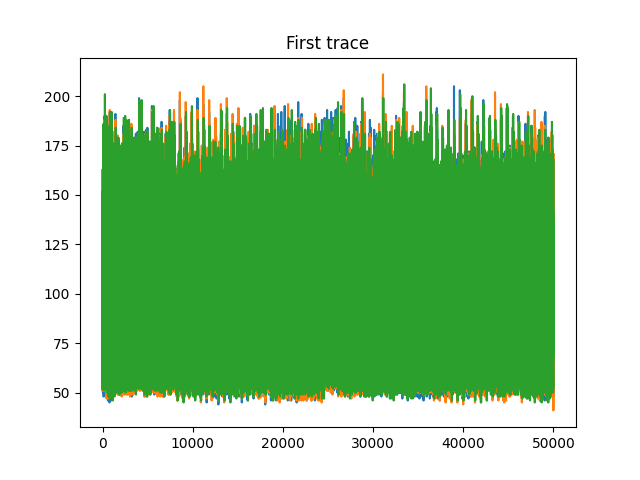

In [87]:
!pip install ipympl
%matplotlib widget
from google.colab import output
output.enable_custom_widget_manager()
fig=plt.figure()
plt.plot(raw_traces[[0, 99, 199]].T) # plotting a vector
plt.title("First trace")
plt.show()

In [88]:
print(inputs.shape) # dimensions of inputs
print(trace_length)
print(raw_traces.shape) # dimensions of matrix of traces

(300, 16)
499999
(300, 50000)


In [89]:

traces_compressed = trace_compression(raw_traces, 10000)
#print(traces_compressed.shape)
traces_integrated = trace_integration(traces_compressed, 50)

#traces_integrated = trace_integration(raw_traces, 100)
#print(traces_integrated)
#traces_aligned = trace_alignment(traces_compressed)
#traces_aligned = trace_alignment(raw_traces)
traces_aligned = trace_alignment(traces_integrated)

print(traces_aligned.shape)
traces = traces_aligned

[-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2,

In [90]:
# If you feel brave enough -- interactive plots
#!pip install ipympl
#from google.colab import output
#output.enable_custom_widget_manager()
#%matplotlib widget

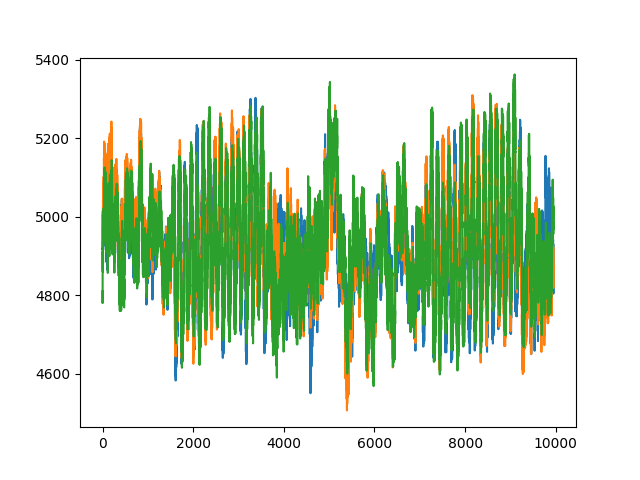

In [91]:
# Plot one trace
fig = plt.figure()
plt.plot(traces[[0, 99, 199]].T)
plt.show()

In [92]:
traces = traces[:, :]

## **Attack the first key byte**
![Intermediate value](dpa-aes-v.png)


In [93]:
# Generate key hypotheses (all possible byte values)
keys = np.arange(start=0, stop=256, step=1, dtype='uint8')
# Select the first byte of each input block
inp = inputs[:, 0]
# XOR each data byte with each key
xmat = inp[:, np.newaxis] ^ keys

In [94]:
# Examine the inputs matrix. Does it contain the data from plaintext.txt?
print(inputs)
# What is the shape of all the operands from the previous cell?
print(inputs.shape)
print(inp.shape)
print(inp[:, np.newaxis].shape)
print(keys.shape)
print(xmat.shape)
# Do you understand the values after the XOR operation? What AES operation do they represent?
print(xmat)

[[ 37 235 140 ...  71 237 252]
 [134  25 178 ... 142  50  68]
 [215 215 233 ...  61  22  57]
 ...
 [231 128  75 ... 111  15  81]
 [247 126 253 ...  60  77   5]
 [255 117  46 ...  56 127  21]]
(300, 16)
(300,)
(300, 1)
(256,)
(300, 256)
[[ 37  36  39 ... 216 219 218]
 [134 135 132 ... 123 120 121]
 [215 214 213 ...  42  41  40]
 ...
 [231 230 229 ...  26  25  24]
 [247 246 245 ...  10   9   8]
 [255 254 253 ...   2   1   0]]


In [95]:
# Substitute with SBOX all XORed values -- matrix of intermediate values
smat = sbox[xmat]

In [96]:
# Compute Hamming Weights -- the matrix of hypothetical power consumption
def power_model(model, smat, xmat):
  if model=="hw":
    return hw_table[smat]
  elif model=="hd":
    return hamming_distance_matrix(smat, xmat)
  else:
    return smat

[[6 4 4 ... 3 5 5]
 [2 4 6 ... 2 5 5]
 [3 6 2 ... 5 4 3]
 ...
 [3 4 5 ... 3 4 5]
 [3 2 5 ... 5 1 2]
 [3 6 3 ... 6 5 4]]
(300, 256)
(300, 9950)
max_acorr 0.530598
key: 0 time: 5364
key:  , 00


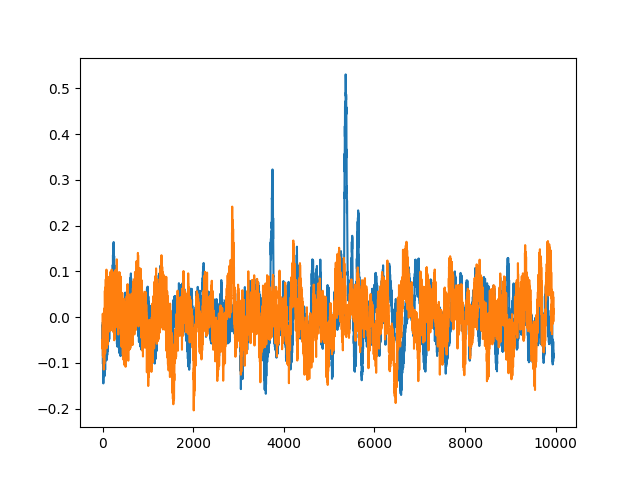

[[3. 2. 6. ... 5. 3. 4.]
 [3. 2. 6. ... 4. 3. 6.]
 [5. 1. 5. ... 6. 3. 3.]
 ...
 [5. 3. 4. ... 4. 5. 5.]
 [6. 4. 3. ... 5. 1. 3.]
 [5. 3. 4. ... 5. 6. 4.]]
(300, 256)
(300, 9950)
max_acorr 0.284794
key: 233 time: 7452
key: é, e9


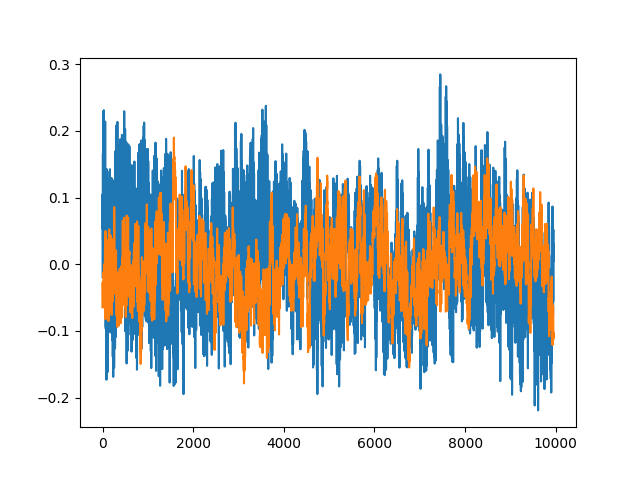

[[ 63  54 204 ...  97 185  87]
 [ 68  23  95 ...  33 188 182]
 [ 14 246   3 ... 229 165  52]
 ...
 [148 142 217 ... 162 212 173]
 [104  66 230 ... 103   1  48]
 [ 22 187  84 ... 119 124  99]]
(300, 256)
(300, 9950)
max_acorr 0.658898
key: 0 time: 5364
key:  , 00


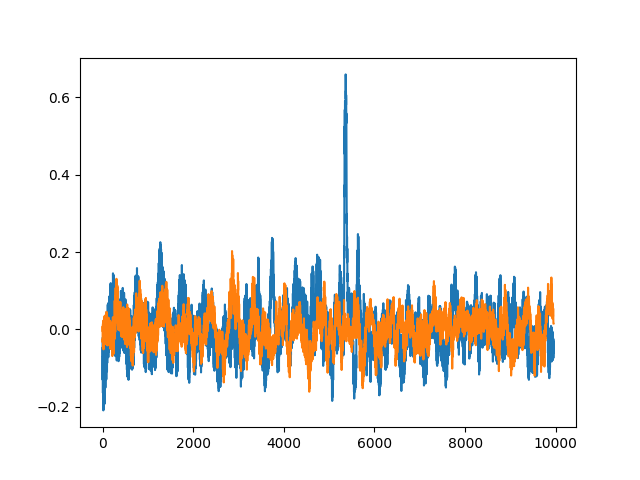

In [97]:
# Compute the correlation matrix -- correlate the hypotheses with measured traces
models = ["hw", "hd", "byte"]
for model in models:
  mat = power_model(model, smat, xmat)
  print(mat)
  print(mat.shape)
  print(traces.shape)
  corr = correlate(mat, traces) 
  # What is the shape and contents of the correlation matrix?
  # Find the absolute maximum correlation
  acorr = abs(corr)
  max_acorr = acorr.max()
  (k, j) = np.where(acorr == max_acorr) # find idices of maximum
  print("max_acorr %f" % max_acorr)
  print("key: %d time: %d" % (k[0], j[0]))
  print("key: %1c, %02x" % (k[0], k[0]))
  # Plot the correlation traces for the right key byte guess and one wrong key byte guess
  # Do you see the correlation peaks?
  fig = plt.figure()
  plt.plot(corr[k[0]])
  plt.plot(corr[k[0]+1])
  plt.show()

## **Break all key bytes!**

In [98]:
def attack(inp, model):
  # Generate key hypotheses (all possible byte values)
  keys = np.arange(start=0, stop=256, step=1, dtype='uint8')
  # XOR each data byte with each key
  xmat = inp[:, np.newaxis] ^ keys
  # Substitute with SBOX all XORed values -- matrix of intermediate values
  smat = sbox[xmat]
  
  mat = power_model(model, smat, xmat)
  corr = correlate(mat, traces) 
  # What is the shape and contents of the correlation matrix?
  # Find the absolute maximum correlation
  acorr = abs(corr)
  max_acorr = acorr.max()
  (k, j) = np.where(acorr == max_acorr) # find idices of maximum
  return k, j

In [99]:
print(inputs)

[[ 37 235 140 ...  71 237 252]
 [134  25 178 ... 142  50  68]
 [215 215 233 ...  61  22  57]
 ...
 [231 128  75 ... 111  15  81]
 [247 126 253 ...  60  77   5]
 [255 117  46 ...  56 127  21]]


In [100]:
models = ["hw"]
kk = np.zeros(16, dtype='uint8')
for model in models:
  for i in range(0, 16):
      inp = inputs[:, i]
      k, j = attack(inp, model)
      kk[i] = k[0]
      print("%1c, %02x @ %d" % (k[0], k[0], j[0]))
  print(kk)

 , 00 @ 5364
, 01 @ 6791
, 02 @ 6558
, 03 @ 5956
, 04 @ 4048
, 05 @ 5399
, 06 @ 6828
, 07 @ 6424
, 08 @ 6294
	, 09 @ 5880
ª, aa @ 5434
», bb @ 6887
Ì, cc @ 6758
Ý, dd @ 6342
î, ee @ 5981
ÿ, ff @ 5491
[  0   1   2   3   4   5   6   7   8   9 170 187 204 221 238 255]


## **Verify the key on a PT, CT pair!**

In [101]:
key_bytes = bytes(kk)
outputs = load_text("/content/drive/MyDrive/lab05_AES_hiding_time/AES_no_trigger/aes_no_trigger_traces/ciphertext.txt")

In [102]:
!pip install pycryptodome
from Crypto.Cipher import AES
cipher = AES.new(key_bytes, AES.MODE_ECB)
msh = cipher.encrypt(bytes(inputs))
outputs = bytes(outputs)
print("Equal = {} \nct is {}\nencrypted pt is {}".format(outputs==msh ,outputs, msh))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Equal = True 
ct is b'\x81\xc63\x9a\xc0\xf1c\x14(E\xeb/<\xd8z\x1b\x8a~C?;\x8c\x98\nn;\xe5\xfc\xeba,|\x16\x0c9,B%\xb9\xc9\xab\xdd\xc4\xc9\xf1_\x83G(U%i\x0b\x0eM\xc0v#\xa7\x8b\x05\xa5\x16\x8f\xda\xbc\xf5J\xb3[\x7f\xdc\xe6\x1e\xb6#q\x10\x93\xc9\x99\xaf\x9e\x0e/65\x82\xec)\x90HaJ\xd5\xdfl\x95\xe2\xef<\x8dT\x9a\x07\xa4\xed\xbe\x80;\xde(8\xca\x8f\x1c-\xee\x9d\x1f\x9c\xf0\xc5O\xaf\x10b\xa23\xd2\no\xfc#\xea8-\x87\x03K\x16\xf7\xda\x1b\xcbT\xb5\xf2\x8eV\xc7\xee\x837#\xd2\xdc\x7f\xd1\x01\xb41\xe3\xcd\xa5%\xef\xba%\xbeh\x07\x10\xf1\xb5\xd5\xf9J\xdb\xa6\xd0\xd0=\x9e\xc1Qj\xb0\x8cwy\x08\xd4\xcb7h\xac(R\xf3\x11\x840nb\xd7\xa4k{\x1aTp3\xf3\x1d\x85\xec0\x83\xe7p!\xf8\x087\x10\xc7+\\\x03\x02\xa5\x1f{\x1e!\xb1i\x96\xdfvY\xb1\x03\x17\x01\x12\x01:\xd6\xa4\x83\x1f<\x98\xa37\xc8\x99\xb2\x19\xe6:\xc4C\xcd\x88\xf2%\xda\x8a\xf8\x8b\xee;\x04s\xc5ld\xedp\xae\x9a\xe8S\xf8\x90\x03\x9e\xaa\xd5\x11\x0e\x1e0\xff2\xe3WDc\

## **PGE**

In [103]:
def PGE(inp, model, traces):
  # Generate key hypotheses (all possible byte values)
  keys = np.arange(start=0, stop=256, step=1, dtype='uint8')
  # XOR each data byte with each key
  xmat = inp[:, np.newaxis] ^ keys
  # Substitute with SBOX all XORed values -- matrix of intermediate values
  smat = sbox[xmat]
  
  mat = power_model(model, smat, xmat)
  corr = correlate(mat, traces) 
  # What is the shape and contents of the correlation matrix?
  # Find the absolute maximum correlation
  acorr = abs(corr)
  max_corr_table = np.zeros(256)
  for i, corr_of_key in enumerate(acorr):
    max_corr_table[i] = corr_of_key.max()

  pge = max_corr_table.argsort()[::-1]
  return pge

  

In [81]:
traces_num = [50,100,200,500]
models = ["hw","hd","byte"]
for trace_num in traces_num:
  sub_traces = traces[:trace_num]
  sub_inputs = inputs[:trace_num]
  for model in models:
    for i in range(0, 16):
        inp = sub_inputs[:, i]
        pge_table = PGE(inp, model, sub_traces)
        pge = np.where(pge_table==kk[i])[0][0]
        print("PGE for {} round is {}".format(i, pge))
        #print(pge[0])



PGE for 0 round is 0
PGE for 1 round is 13
PGE for 2 round is 233
PGE for 3 round is 83
PGE for 4 round is 131
PGE for 5 round is 23
PGE for 6 round is 0
PGE for 7 round is 63
PGE for 8 round is 199
PGE for 9 round is 58
PGE for 10 round is 55
PGE for 11 round is 61
PGE for 12 round is 106
PGE for 13 round is 42
PGE for 14 round is 0
PGE for 15 round is 192
PGE for 0 round is 234
PGE for 1 round is 35
PGE for 2 round is 193
PGE for 3 round is 75
PGE for 4 round is 175
PGE for 5 round is 220
PGE for 6 round is 125
PGE for 7 round is 2
PGE for 8 round is 185
PGE for 9 round is 24
PGE for 10 round is 118
PGE for 11 round is 7
PGE for 12 round is 32
PGE for 13 round is 44
PGE for 14 round is 224
PGE for 15 round is 179
PGE for 0 round is 10
PGE for 1 round is 3
PGE for 2 round is 190
PGE for 3 round is 1
PGE for 4 round is 80
PGE for 5 round is 13
PGE for 6 round is 11
PGE for 7 round is 7
PGE for 8 round is 145
PGE for 9 round is 27
PGE for 10 round is 0
PGE for 11 round is 116
PGE for 12